In [1]:
from numpy import inf
from classifiers.MultivariateGaussianClassifier import *
from classifiers.NaiveBayesClassifier import *
from classifiers.TiedCovarianceGaussianClassifier import *
from classifiers.TiedDiagCovGaussianClassifier import *
from classifiers.LogisticRegression import *
from classifiers.LinearSVM import *
from classifiers.KernelSVM import *
from classifiers.GaussianMixtureModel import *
from transformers.PCA import *
from transformers.Gaussianizer import *
from tabulate import tabulate
import concurrent.futures
from tqdm import tqdm


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
DTR, LTR = load_data('./data/Train.txt')
DTE, LTE = load_data('./data/Test.txt')
priors = numpy.array([0.5, 0.1, 0.9])
load_saved = True

In [16]:
#####################################################################################
# Gaussian Models
#####################################################################################

classifier_name = numpy.array([
    'Full-Cov',
    'Diag-Cov',
    'Tied Full-Cov',
    'Tied Diag-Cov'
])
classifiers = numpy.array([
    MultivariateGaussianClassifier,
    NaiveBayesClassifier,
    TiedCovarianceGaussianClassifier,
    TiedDiagCovGaussianClassifier
])
transformers = [
    [Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [],
    [PCA]
]
transf_args = [
    [()],
    [(7,), ()],
    [(6,), ()],
    [(5,), ()],
    [()],
    [(7,)]
]
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0]))
llr = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_GAU_models.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
            for c, C in enumerate(classifiers):
                for p, P in enumerate(priors):
                    print(str(t) + " - " + classifier_name[c] + ", π = " + str(P))
                    llr[t, c, p] = C(DTrain, LTR).llr(DTest)
                    mindcf[t, c, p] = min_DCF(llr[t, c, p], LTE, P, 1, 1)
                    progress.update()
    table = numpy.hstack((vcol(classifier_name), mindcf[t]))
    print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_GAU_models', mindcf)

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.151 │ 0.242 │ 0.62  │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.154 │ 0.285 │ 0.574 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.126 │ 0.222 │ 0.54  │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.158 │ 0.301 │ 0.568 │
╘═══════════════╧═══════╧═══════╧═══════╛
╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.165 │ 0.41  │ 0.649 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.2   │ 0.42  │ 0.633 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.196 │ 0.307 │ 0.716 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.159 │ 0.293 │ 0.606 │
╘═══════════════╧═══════╧═══════╧═══════╛
╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │ 

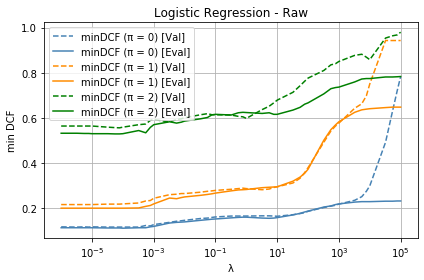

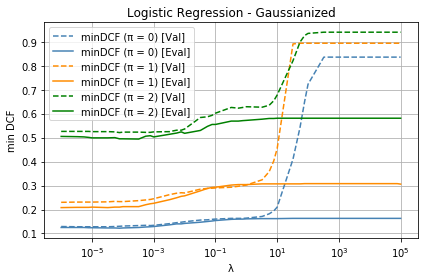

In [17]:
#######################################################################################
# Logistic Regression
#######################################################################################

transformers = [
    [],
    [Gaussianizer]
]
transf_args = [
    [()],
    [()]
]

lamb = numpy.array([10 ** i for i in range(-6, 6)])
lamb = numpy.array([numpy.linspace(lamb[i], lamb[i + 1], 5) for i in range(lamb.shape[0] - 1)]).reshape(-1)
llr = numpy.zeros((len(transformers), lamb.shape[0], DTE.shape[1]))
mindcf = numpy.zeros((len(transformers), priors.shape[0], lamb.shape[0]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_LogReg_lamb.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=lamb.shape[0], colour='green') as progress:
            for l, L in enumerate(lamb):
                print(str(t) + " - Logistic Regression, π = " + str(priors) + ', λ = ' + str(L))
                llr[t, l] = LogisticRegression(DTrain, LTR, L).llr(DTest)
                for p, P in enumerate(priors):
                    mindcf[t, p, l] = min_DCF(llr[t, l], LTE, P, 1, 1)
                progress.update()
    # table = numpy.hstack((vcol(numpy.array(['Logistic Regression'])), mindcf[t].min(axis=1, initial=inf)))
    # print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_LogReg_lamb', mindcf)
mindcf_train = numpy.load('./data/minDCF_LogReg_lamb.npy')

for t, Ts in enumerate(transformers):
    plt.figure()
    colors = ['steelblue', 'darkorange', 'g']
    for p, P in enumerate(priors):
        plt.plot(lamb, mindcf_train[t, 0, p], label='minDCF (π = ' + str(P) + ') [Val]', linestyle='dashed', color=colors[p])
        plt.plot(lamb, mindcf[t, p], label='minDCF (π = ' + str(P) + ') [Eval]', color=colors[p])
    plt.xlabel('λ')
    plt.ylabel('min DCF')
    plt.title('Logistic Regression - ' + ('Raw' if t == 0 else 'Gaussianized'))
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('./plots/mindcf_eval/LogReg_lamb_' + ('Raw' if t == 0 else 'Gaussianized') + '.png')
    plt.show()

In [18]:
#######################################################################################
# Logistic Regression - λ = 0
#######################################################################################

lamb = 0
classifier_name = numpy.array([
    "Log Reg (λ = " + str(lamb) + ")",
    "Log Reg (λ = " + str(lamb) + ", π = 0.5)",
])
class_prior = [None, [0.9, 0.1]]
classifiers = numpy.array([
    LogisticRegression,
    LogisticRegression
])
transformers = [
    [],
    [Gaussianizer],
]
transf_args = [
    [()],
    [()],
]
llr = numpy.zeros((len(transformers), classifiers.shape[0], DTE.shape[1]))
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_LogReg_lamb_fixed.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
            for c, C in enumerate(classifiers):
                llr[t, c] = LogisticRegression(DTrain, LTR, lamb=0, x0=None, prior=class_prior[c]).llr(DTest)
                for p, P in enumerate(priors):
                    print(str(t) + " - " + classifier_name[c] + ", π = " + str(P))
                    mindcf[t, c, p] = min_DCF(llr[t, c], LTE, P, 1, 1)
                    progress.update()
    table = numpy.hstack((vcol(classifier_name), mindcf[t]))
    print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_LogReg_lamb_fixed', mindcf)

╒══════════════════════════╤═══════╤═══════╤═══════╕
│                          │   0.5 │   0.1 │   0.9 │
╞══════════════════════════╪═══════╪═══════╪═══════╡
│ Log Reg (λ = 0)          │ 0.111 │ 0.199 │ 0.53  │
├──────────────────────────┼───────┼───────┼───────┤
│ Log Reg (λ = 0, π = 0.5) │ 0.107 │ 0.199 │ 0.542 │
╘══════════════════════════╧═══════╧═══════╧═══════╛
╒══════════════════════════╤═══════╤═══════╤═══════╕
│                          │   0.5 │   0.1 │   0.9 │
╞══════════════════════════╪═══════╪═══════╪═══════╡
│ Log Reg (λ = 0)          │ 0.125 │ 0.208 │ 0.507 │
├──────────────────────────┼───────┼───────┼───────┤
│ Log Reg (λ = 0, π = 0.5) │ 0.122 │ 0.215 │ 0.485 │
╘══════════════════════════╧═══════╧═══════╧═══════╛


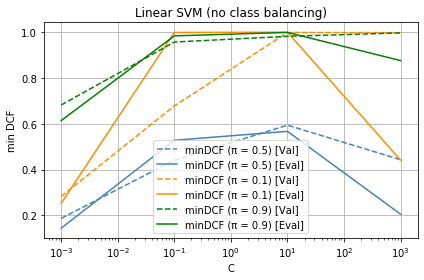

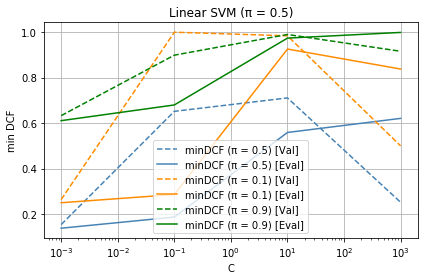

In [19]:
##################################################################################
# Linear SVM
##################################################################################

classifier_name = numpy.array([
    'Linear SVM (no class balancing)',
    'Linear SVM (π = 0.5)'
])
classifiers = numpy.array([
    LinearSVM,
    LinearSVM
])
transformers = [
    [],
]
transf_args = [
    [()],
]

Ci = numpy.array([10 ** i for i in range(-3, 4, 2)])
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0], Ci.shape[0]))
llr = numpy.zeros((len(transformers), classifiers.shape[0], Ci.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_LinearSVM_C.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=priors.shape[0] * Ci.shape[0], colour='green') as progress:
            for c, C in enumerate(Ci):
                print(str(t) + " - " + classifier_name[0] + " - π = " + str(priors))
                llr[t, 0, c] = LinearSVM(DTrain, LTR, C=C).llr(DTest)
                print(str(t) + " - " + classifier_name[1] + " - π = " + str(priors))
                llr[t, 1, c] = LinearSVM(DTrain, LTR, C=C, prior=0.5).llr(DTest)
                for p, P in enumerate(priors):
                    mindcf[t, 0, p, c] = min_DCF(llr[t, 0, c], LTE, P, 1, 1)
                    mindcf[t, 1, p, c] = min_DCF(llr[t, 1, c], LTE, P, 1, 1)
                    progress.update()

numpy.save('./data/evaluation/minDCF_LinearSVM_C.npy', mindcf)
mindcf_train = numpy.load('./data/minDCF_LinearSVM_C.npy')

for t, Ts in enumerate(transformers):
    for c, C in enumerate(classifier_name):
        plt.figure()
        colors = ['steelblue', 'darkorange', 'g']
        for p, P in enumerate(priors):
            plt.plot(Ci, mindcf_train[t, c, p], label='minDCF (π = ' + str(P) + ') [Val]', linestyle='dashed', color=colors[p])
            plt.plot(Ci, mindcf[t, c, p], label='minDCF (π = ' + str(P) + ') [Eval]', color=colors[p])
        plt.xlabel('C')
        plt.ylabel('min DCF')
        plt.title(C)
        plt.xscale('log')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('./plots/mindcf_eval/LinearSVM_C_' + ('unbalanced' if c == 0 else 'balanced') + '.png')
        plt.show()

In [20]:
##################################################################################
# Linear SVM - C = 1e-3
##################################################################################

C = 1e-3  # chosen from previous step
classifier_name = numpy.array([
    'Linear SVM (no class balancing, C = ' + str(C) + ') ',
    'Linear SVM (π = 0.5, C = ' + str(C) + ')'
])
classifiers = numpy.array([
    LinearSVM,
    LinearSVM
])
transformers = [
    [],
]
transf_args = [
    [()],
]
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0]))
llr = numpy.zeros((len(transformers), classifiers.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_LinearSVM_C_fixed.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=priors.shape[0], colour='green') as progress:
            print(str(t) + " - " + classifier_name[0] + ", π = " + str(priors))
            llr[t, 0] = LinearSVM(DTrain, LTR, C=C).llr(DTest)
            print(str(t) + " - " + classifier_name[1] + ", π = " + str(priors))
            llr[t, 1] = LinearSVM(DTrain, LTR, C=C, prior=0.5).llr(DTest)
            for p, P in enumerate(priors):
                mindcf[t, 0, p] = min_DCF(llr[t, 0], LTE, P, 1, 1)
                mindcf[t, 1, p] = min_DCF(llr[t, 1], LTE, P, 1, 1)
                progress.update()
    table = numpy.hstack((vcol(classifier_name), mindcf[t]))
    print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_LinearSVM_C_fixed.npy', mindcf)

╒════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                            │   0.5 │   0.1 │   0.9 │
╞════════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ Linear SVM (no class balancing, C = 0.001) │ 0.144 │ 0.253 │ 0.614 │
├────────────────────────────────────────────┼───────┼───────┼───────┤
│ Linear SVM (π = 0.5, C = 0.001)            │ 0.138 │ 0.25  │ 0.611 │
╘════════════════════════════════════════════╧═══════╧═══════╧═══════╛


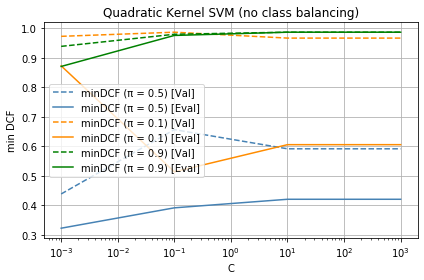

In [21]:
##################################################################################
# Quadratic kernel SVM
##################################################################################

classifier_name = numpy.array([
    'Quadratic Kernel SVM (no class balancing)'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]

Ci = numpy.array([10 ** i for i in range(-3, 4, 2)])
mindcf = numpy.zeros((len(transformers), priors.shape[0], Ci.shape[0]))
llr = numpy.zeros((len(transformers), Ci.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_PolySVM_C.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=priors.shape[0] * Ci.shape[0], colour='green') as progress:
            for c, C in enumerate(Ci):
                print(str(t) + " - " + classifier_name[0] + " - π = " + str(priors))
                llr[t, c] = KernelSVM(DTrain, LTR, C=C, kernel='poly', kernel_args=(0, 2)).llr(DTest)
                for p, P in enumerate(priors):
                    mindcf[t, p, c] = min_DCF(llr[t, c], LTE, P, 1, 1)
                    mindcf[t, p, c] = min_DCF(llr[t, c], LTE, P, 1, 1)
                    progress.update()

numpy.save('./data/evaluation/minDCF_PolySVM_C.npy', mindcf)
mindcf_train = numpy.load('./data/minDCF_PolySVM_C.npy')

for t, Ts in enumerate(transformers):
    plt.figure()
    colors = ['steelblue', 'darkorange', 'g']
    for p, P in enumerate(priors):
        plt.plot(Ci, mindcf_train[t, 0, p], label='minDCF (π = ' + str(P) + ') [Val]', linestyle='dashed',
                 color=colors[p])
        plt.plot(Ci, mindcf[t, p], label='minDCF (π = ' + str(P) + ') [Eval]', color=colors[p])
    plt.xlabel('C')
    plt.ylabel('min DCF')
    plt.title('Quadratic Kernel SVM (no class balancing)')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('./plots/mindcf_eval/PolySVM_C.png')
    plt.show()

In [22]:
##################################################################################
# Quadratic kernel SVM - C = 1e-3
##################################################################################

C = 1e-3
classifier_name = numpy.array([
    'Quadratic Kernel SVM (π = 0.5, C = ' + str(C) + ')'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]

mindcf = numpy.zeros((len(transformers), priors.shape[0]))
llr = numpy.zeros((len(transformers), DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_PolySVM_C_fixed.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=priors.shape[0], colour='green') as progress:
            print(str(t) + " - " + classifier_name[0] + " - π = " + str(priors))
            llr[t] = KernelSVM(DTrain, LTR, C=C, kernel='poly', kernel_args=(0, 2)).llr(DTest)
            for p, P in enumerate(priors):
                mindcf[t, p] = min_DCF(llr[t], LTE, P, 1, 1)
                mindcf[t, p] = min_DCF(llr[t], LTE, P, 1, 1)
                progress.update()
    table = numpy.hstack((vcol(classifier_name), vrow(mindcf[t])))
    print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_PolySVM_C_fixed.npy', mindcf)


╒═══════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                           │   0.5 │   0.1 │   0.9 │
╞═══════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ Quadratic Kernel SVM (π = 0.5, C = 0.001) │ 0.323 │ 0.873 │ 0.871 │
╘═══════════════════════════════════════════╧═══════╧═══════╧═══════╛


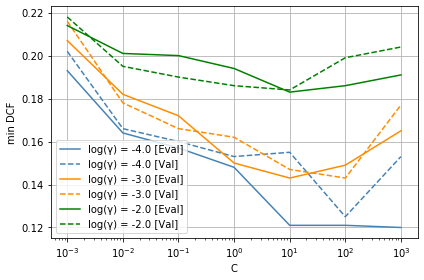

In [23]:
##################################################################################
# RBF kernel SVM
##################################################################################

classifier_name = numpy.array([
    'RBF Kernel SVM (no class balancing)'
])
classifiers = numpy.array([
    KernelSVM,
])
transformers = [
    [],
]
transf_args = [
    [()],
]

Ci = numpy.array([10 ** i for i in range(-3, 4)])
gamma_i = numpy.array([10 ** i for i in range(-4, -1)])

mindcf = numpy.zeros((len(transformers), gamma_i.shape[0], Ci.shape[0]))
llr = numpy.zeros((len(transformers), gamma_i.shape[0], Ci.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_RBF_SVM_C_gamma.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=gamma_i.shape[0] * Ci.shape[0], colour='green') as progress:
            for g, gamma in enumerate(gamma_i):
                for c, C in enumerate(Ci):
                    print(str(t) + " - " + classifier_name[0] + ", π = 0.5, log(γ) = " + str(numpy.log10(gamma)) + ", log(C) = " + str(numpy.log10(C)))
                    llr[t, g, c] = KernelSVM(DTrain, LTR, C=C, kernel='rbf', kernel_args=(gamma,)).llr(DTest)
                    mindcf[t, g, c] = min_DCF(llr[t, g, c], LTE, 0.5, 1, 1)
                    progress.update()

numpy.save('./data/evaluation/minDCF_RBF_SVM_C_gamma.npy', mindcf)
mindcf_train = numpy.load('./data/minDCF_RBF_SVM_C_gamma.npy')

for t, T in enumerate(transformers):
    plt.figure()
    colors = ['steelblue', 'darkorange', 'g']
    for g, gamma in enumerate(gamma_i):
        plt.plot(Ci, mindcf[t, g], label='log(γ) = ' + str(numpy.log10(gamma)) + ' [Eval]', color=colors[g])
        plt.plot(Ci, mindcf_train[t, 0, 0, g], label='log(γ) = ' + str(numpy.log10(gamma)) + ' [Val]', linestyle='dashed', color=colors[g])
    plt.xlabel('log(C)')
    plt.ylabel('min DCF')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig('./plots/mindcf_eval/RBF_SVM_C_gamma.png')
    plt.show()


In [24]:
##################################################################################
# RBF kernel SVM - log(γ) = -4, log(C) = 2
##################################################################################

C = 1e2
gamma = 1e-4
classifier_name = numpy.array([
    'RBF Kernel SVM (no class balancing)',
    'RBF Kernel SVM (π = 0.5, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
    'RBF Kernel SVM (π = 0.1, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
    'RBF Kernel SVM (π = 0.9, log(C) = ' + str(numpy.log10(C)) + ', log(γ) = ' + str(numpy.log10(gamma)) + ')',
])
class_prior = numpy.array([0.5, 0.1, 0.9])
classifiers = numpy.array([
    KernelSVM,
    KernelSVM,
    KernelSVM,
    KernelSVM,
])
transformers = [
    [], [Gaussianizer]
]
transf_args = [
    [()], [()],
]
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], priors.shape[0]))
llr = numpy.zeros((len(transformers), classifiers.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.around(numpy.load('./data/evaluation/minDCF_RBF_SVM_C_gamma_fixed.npy'), 3)

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
            for c in range(classifiers.shape[0]):
                print(classifier_name[c] + ", π = " + str(priors) + ", log(γ) = " + str(numpy.log10(gamma)) + ", log(C) = " + str(numpy.log10(C)))
                llr[t, c] = KernelSVM(DTrain, LTR, C=C, prior=(class_prior[c - 1] if c > 0 else None), kernel='rbf', kernel_args=(gamma,)).llr(DTest)
                for p, P in enumerate(priors):
                    mindcf[t, c, p] = min_DCF(llr[t, c], LTE, P, 1, 1)
    table = numpy.hstack((vcol(classifier_name), mindcf[t]))
    print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

numpy.save('./data/evaluation/minDCF_RBF_SVM_C_gamma_fixed.npy', mindcf)

╒═══════════════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│                                                       │   0.5 │   0.1 │   0.9 │
╞═══════════════════════════════════════════════════════╪═══════╪═══════╪═══════╡
│ RBF Kernel SVM (no class balancing)                   │ 0.121 │ 0.206 │ 0.746 │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.5, log(C) = 2.0, log(γ) = -4.0) │ 0.118 │ 0.219 │ 0.521 │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.1, log(C) = 2.0, log(γ) = -4.0) │ 0.114 │ 0.211 │ 0.649 │
├───────────────────────────────────────────────────────┼───────┼───────┼───────┤
│ RBF Kernel SVM (π = 0.9, log(C) = 2.0, log(γ) = -4.0) │ 0.155 │ 0.359 │ 0.603 │
╘═══════════════════════════════════════════════════════╧═══════╧═══════╧═══════╛
╒═══════════════════════════════════════════════════════╤═══════╤═══════╤═══════╕
│               

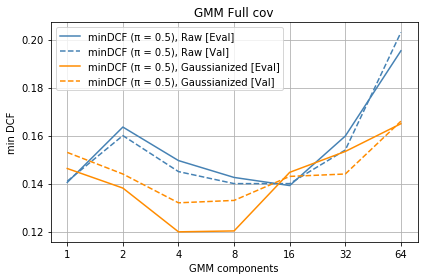

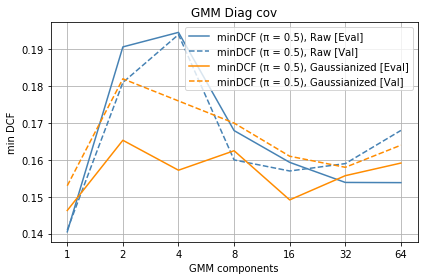

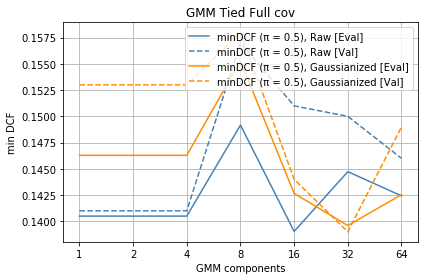

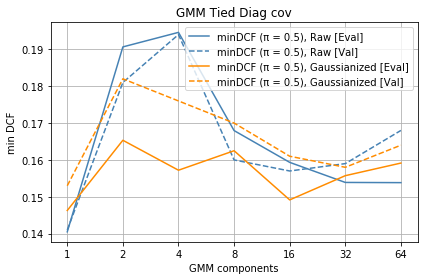

In [25]:
######################################################################################
# GMM
######################################################################################

classifier_name = numpy.array([
    'GMM Full cov',
    'GMM Diag cov',
    'GMM Tied Full cov',
    'GMM Tied Diag cov'
])
classifiers = numpy.array([
    GaussianMixtureModel,
    GaussianMixtureModel,
    GaussianMixtureModel,
    GaussianMixtureModel,
])
n_g_max = 64
n_g = numpy.array([2 ** i for i in range(int(numpy.log2(n_g_max)) + 1)])

prior = 0.5
transformers = [
    [],
    [Gaussianizer],
]
transf_args = [
    [()],
    [()],
]
mindcf = numpy.zeros((len(transformers), classifiers.shape[0], n_g.shape[0]))
llr = numpy.zeros((len(transformers), classifiers.shape[0], n_g.shape[0], DTE.shape[1]))

if load_saved:
    mindcf = numpy.load('./data/evaluation/minDCF_GMM_n_g.npy')

for t, Ts in enumerate(transformers):
    if not load_saved:
        DTrain = DTR
        DTest = DTE
        for i, Tc in enumerate(Ts):
            T = Tc().fit(DTrain, *transf_args[t][i])
            DTrain = T.transform(DTrain)
            DTest = T.transform(DTest)
        with tqdm(total=classifiers.shape[0], colour='green') as progress:
            for c in range(classifiers.shape[0]):
                print(str(t) + " - " + classifier_name[c] + ", π = " + str(prior))
                C = GaussianMixtureModel(DTrain, LTR, c == 1 or c == 3, c == 2 or c == 3, n_g_max)
                for g, n_g_i in enumerate(n_g):
                    llr[t, c, g] = C.llr(DTest, n_g_i)
                    mindcf[t, c, g] = min_DCF(llr[t, c, g], LTE, prior, 1, 1)

numpy.save('./data/evaluation/minDCF_GMM_n_g.npy', mindcf)
mindcf_train = numpy.load('./data/minDCF_GMM_n_g.npy')

colors = ['steelblue', 'darkorange']
for c in range(classifiers.shape[0]):
    plt.figure()
    for t in range(len(transformers)):
        name = 'Raw' if t == 0 else 'Gaussianized'
        plt.plot(numpy.log2(n_g), mindcf[t, c], label='minDCF (π = ' + str(prior) + '), ' + name + ' [Eval]', color=colors[t])
        plt.plot(numpy.log2(n_g), mindcf_train[t, c], label='minDCF (π = ' + str(prior) + '), ' + name + ' [Val]', color=colors[t], linestyle='dashed')
        plt.xlabel('GMM components')
        plt.ylabel('min DCF')
        plt.legend()
        plt.grid(True)
        plt.title(classifier_name[c])
        plt.xticks(numpy.log2(n_g), n_g)
        plt.tight_layout()
        plt.savefig('./plots/mindcf_eval/GMM_' + classifier_name[c] + '_n_g.png')
    plt.show()

In [26]:
print("START")
llr_tied_full_train = TiedCovarianceGaussianClassifier(DTR, LTR).llr(DTR)
llr_LogReg_train = LogisticRegression(DTR, LTR, lamb=0).llr(DTR)
llr_tied_full = TiedCovarianceGaussianClassifier(DTR, LTR).llr(DTE)
llr_LogReg = LogisticRegression(DTR, LTR, lamb=0).llr(DTE)
print("DONE")

START
DONE


100%|██████████| 8969/8969 [00:12<00:00, 703.29it/s]


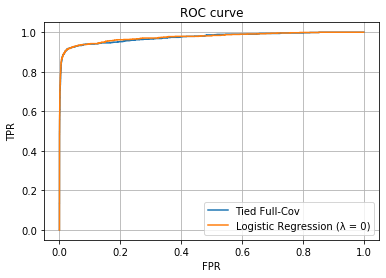

In [3]:
##################################################################
# ROC
##################################################################

llr_tied_full_train = TiedCovarianceGaussianClassifier(DTR, LTR).llr(DTR)
llr_LogReg_train = LogisticRegression(DTR, LTR, lamb=0).llr(DTR)
llr_tied_full = TiedCovarianceGaussianClassifier(DTR, LTR).llr(DTE)
llr_LogReg = LogisticRegression(DTR, LTR, lamb=0).llr(DTE)

scores_tied = numpy.sort(llr_tied_full)
FPR_arr_tied = []
TPR_arr_tied = []
for threshold in tqdm(scores_tied):
    predicted = 0 + (llr_tied_full > threshold)
    confusion_matrix_roc = compute_confusion_matrix(LTE, predicted)
    FNR = confusion_matrix_roc[0, 1] / sum(confusion_matrix_roc[:, 1])
    FPR = confusion_matrix_roc[1, 0] / sum(confusion_matrix_roc[:, 0])
    TPR = 1 - FNR
    FPR_arr_tied.append(FPR)
    TPR_arr_tied.append(TPR)

scores_logreg = numpy.sort(llr_LogReg)
FPR_arr_logreg = []
TPR_arr_logreg = []
for threshold in tqdm(scores_logreg):
    predicted = 0 + (llr_LogReg > threshold)
    confusion_matrix_roc = compute_confusion_matrix(LTE, predicted)
    FNR = confusion_matrix_roc[0, 1] / sum(confusion_matrix_roc[:, 1])
    FPR = confusion_matrix_roc[1, 0] / sum(confusion_matrix_roc[:, 0])
    TPR = 1 - FNR
    FPR_arr_logreg.append(FPR)
    TPR_arr_logreg.append(TPR)

plt.figure()
plt.grid(True)
plt.plot(FPR_arr_tied, TPR_arr_tied, label='Tied Full-Cov')
plt.plot(FPR_arr_logreg, TPR_arr_logreg, label='Logistic Regression (λ = 0)')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curve')
plt.savefig('./plots/mindcf_eval/ROC.png')
plt.show()

100%|██████████| 21/21 [08:48<00:00, 25.16s/it]


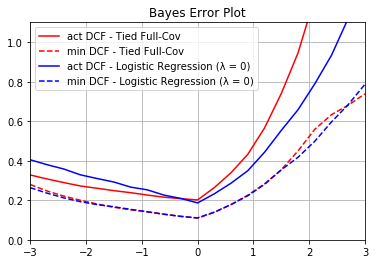

In [29]:
##################################################################
# Bayes error plots
##################################################################

effPriorLogOdds = numpy.linspace(-3, 3, 21)
p_arr = 1 / (1 + numpy.exp(-effPriorLogOdds))
dcf_tied = []
mindcf_tied = []
dcf_logreg = []
mindcf_logreg = []
for i in tqdm(range(len(p_arr))):
    predicted_tied = optimal_binary_bayes_decisions(p_arr[i], 1, 1, llr_tied_full)
    confusion_matrix = compute_confusion_matrix(LTE, predicted_tied)
    dcf_tied.append(DCF(p_arr[i], 1, 1, confusion_matrix))
    mindcf_tied.append(min_DCF(llr_tied_full, LTE, p_arr[i], 1, 1))

    predicted_logreg = optimal_binary_bayes_decisions(p_arr[i], 1, 1, llr_LogReg)
    confusion_matrix = compute_confusion_matrix(LTE, predicted_logreg)
    dcf_logreg.append(DCF(p_arr[i], 1, 1, confusion_matrix))
    mindcf_logreg.append(min_DCF(llr_LogReg, LTE, p_arr[i], 1, 1))

plt.figure()
plt.grid(True)
plt.plot(effPriorLogOdds, dcf_tied, label='act DCF - Tied Full-Cov', color='r')
plt.plot(effPriorLogOdds, mindcf_tied, label='min DCF - Tied Full-Cov', color='r', linestyle='dashed')
plt.plot(effPriorLogOdds, dcf_logreg, label='act DCF - Logistic Regression (λ = 0)', color='b')
plt.plot(effPriorLogOdds, mindcf_logreg, label='min DCF - Logistic Regression (λ = 0)', color='b',
         linestyle='dashed')
plt.legend()
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.title('Bayes Error Plot')
plt.savefig('./plots/mindcf_eval/Bayes_error_plot.png')
plt.show()

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
100%|██████████| 21/21 [17:27<00:00, 49.88s/it]


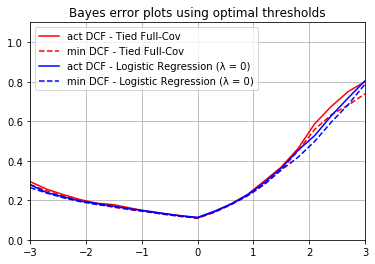

In [30]:
##################################################################
# Bayes error plots - Optimal threshold
##################################################################

effPriorLogOdds = numpy.linspace(-3, 3, 21)
p_arr = 1 / (1 + numpy.exp(-effPriorLogOdds))
dcf_tied = []
mindcf_tied = []
dcf_logreg = []
mindcf_logreg = []
for i in tqdm(range(len(p_arr))):
    _, threshold = min_DCF(llr_tied_full_train, LTR, p_arr[i], 1, 1, returnThreshold=True)
    predicted = optimal_binary_bayes_decisions(threshold, 1, 1, llr_tied_full, useThreshold=True)
    confusion_matrix = compute_confusion_matrix(LTE, predicted)
    mindcf_tied.append(min_DCF(llr_tied_full, LTE, p_arr[i], 1, 1))
    dcf_tied.append(DCF(p_arr[i], 1, 1, confusion_matrix))

    _, threshold = min_DCF(llr_LogReg_train, LTR, p_arr[i], 1, 1, returnThreshold=True)
    predicted = optimal_binary_bayes_decisions(threshold, 1, 1, llr_LogReg, useThreshold=True)
    confusion_matrix = compute_confusion_matrix(LTE, predicted)
    mindcf_logreg.append(min_DCF(llr_LogReg, LTE, p_arr[i], 1, 1))
    dcf_logreg.append(DCF(p_arr[i], 1, 1, confusion_matrix))

plt.figure()
plt.grid(True)
plt.plot(effPriorLogOdds, dcf_tied, label='act DCF - Tied Full-Cov', color='r')
plt.plot(effPriorLogOdds, mindcf_tied, label='min DCF - Tied Full-Cov', color='r', linestyle='dashed')
plt.plot(effPriorLogOdds, dcf_logreg, label='act DCF - Logistic Regression (λ = 0)', color='b')
plt.plot(effPriorLogOdds, mindcf_logreg, label='min DCF - Logistic Regression (λ = 0)', color='b',
         linestyle='dashed')
plt.legend()
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.title('Bayes error plots using optimal thresholds')
plt.savefig('./plots/mindcf_eval/Bayes_error_plot_opt_thresholds.png')
plt.show()